---
title: "Wind Power Forecasting"
format:
    html:
        code-fold: true
jupyter: REStats
warning: false
echo: false
---

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import arviz as az
import pymc as pm
import seaborn as sns

from REStats.utils import load_SCADA

In [2]:
# cmap = mpl.colormaps['tab10']
sns.set_theme()

In [3]:
wt = load_SCADA(2020)

## Bayesian Approach

In standard regression, we model the power at a given time $y_t$ as a linear combination of its lagged values and parameter vector ${\rho}$,

$$
y_t = \alpha + \rho_1 y_{t-1} + ... + \rho_n y_{t-n}
$$

In a Bayesian approach, we model $y_t$ as following a normal distribution with mean $\mu_t$ and standard deviation $\sigma$. For example:

$$
\begin{align}
y_t & \sim \mathcal{N}(\mu_t, \sigma) \\
\mu_t & = \alpha + \rho_1 y_{t-1} + ... + \rho_n y_{t-n} \\
\alpha & \sim \mathcal{N}(0, 10) \\
\rho & \sim \mathcal{N}(0, 1) \\
\sigma & \sim \text{HalfNormal}(1) \\
\end{align} 
$$

This project proposes an AR(3) model with weakly informative priors,

$$
\begin{align}
y_t & \sim \mathcal{N}(\mu_t, \sigma) \\
\mu_t & = \rho_1 y_{t-1} + \rho_2 y_{t-2} + \rho_3 y_{t-3} \\
\rho & \sim \mathcal{N}(0, 1) \\
\sigma & \sim \text{HalfNormal}(1) \\
\end{align} 
$$


In [4]:
def standardize(data, train):
    return (data - train.mean())/train.std()


def inverse_transform(data, train):
    return data * train.std() + train.mean()

In [5]:
def predict(power, lags=3, steps=1):
    assert len(power) == lags
    
    predictions = np.flip(np.copy(power))
    
    for s in range(steps):
        pred = np.dot(post_mean.rho, predictions[-lags:])
        predictions = np.append(
            predictions, pred
        )
        
    return predictions[lags:]

In [6]:
def backtest(data, lags, steps=1):
    predictions = np.zeros(len(data))
    current = 0
    rmse = np.zeros(len(data))
    mae = np.zeros(len(data))
    
    data_s = standardize(data, y_train)

    while current < len(data):
        if current < lags:
            predictions[current] = data[current]
            rmse[current] = 0
            mae[current] = 0
        else:
            window = data_s[(current-lags):current]
            pred_s = predict(window, lags=lags, steps=steps)
            pred = inverse_transform(pred_s, y_train)
            predictions[current] = pred[0]

            y_true = data[current:current+steps].values
    
            if len(y_true) == len(pred):
                rmse[current] = mean_squared_error(y_true=y_true, y_pred=pred, squared=False)
                mae[current] = sum(abs(y_true - pred))/len(pred)
                
        current += 1
        
    error = {
        "rmse": np.average(rmse),
        "mae": np.average(mae)
    }

    return error, predictions

## Wind -> Power

This approach takes advantage of the fact that wind speeds follow a Weibull distribution. By fitting the curve to find the shape $\alpha$ and scale $\beta$ parameters, we can apply a transformation to make the curve more Gaussian, after which we can standardize the data as before.

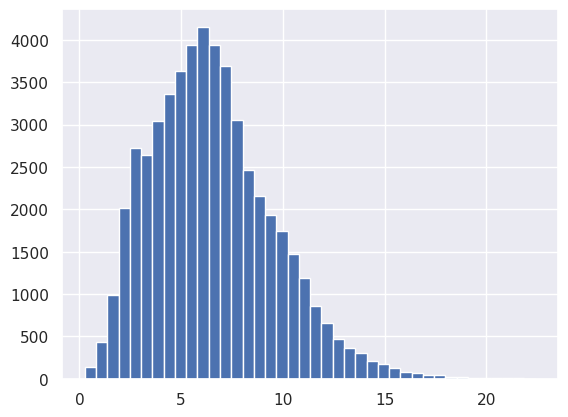

In [7]:
fig, ax = plt.subplots()

d = ax.hist(wt["Wind speed"], bins=40)

In [8]:
wt_1m = wt[(wt.index >= "2020-02-01") & (wt.index < "2020-03-01")]

ws = wt_1m["Wind speed"]

In [9]:
ws.isnull().sum() == 0, len(ws)

(True, 4176)

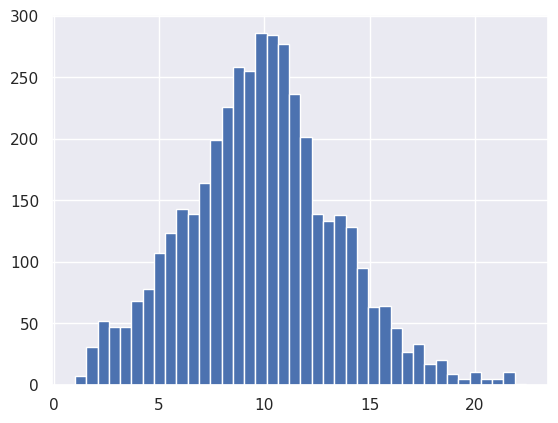

In [10]:
fig, ax = plt.subplots()

d = ax.hist(ws, bins=40)

In [11]:
#| output: false

with pm.Model() as wb_model:
    alpha = pm.HalfNormal("alpha", 1)
    beta = pm.HalfNormal("beta", 1)
    weibull = pm.Weibull("weibull", alpha=alpha, beta=beta, observed=ws)
    
    idata_wb = pm.sample(2000, random_seed=100)
    pm.sample_posterior_predictive(idata_wb, extend_inferencedata=True)
    pm.compute_log_likelihood(idata_wb)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 11 seconds.
Sampling: [weibull]


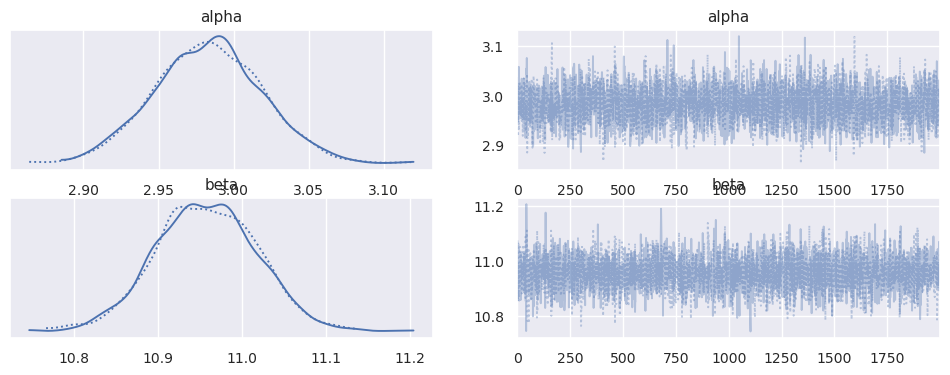

In [12]:
p = az.plot_trace(idata_wb)

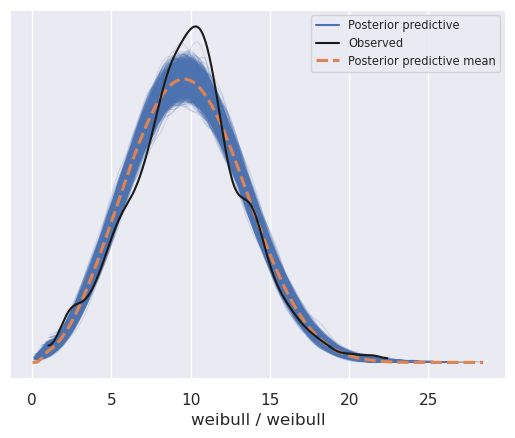

In [13]:
p = az.plot_ppc(idata_wb)

In [14]:
pm.loo(idata_wb)

Computed from 4000 posterior samples and 4176 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -11212.86    44.85
p_loo        2.23        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     4176  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [15]:
post = idata_wb.posterior
p_mean = post.mean(["chain", "draw"])
p_mean

<xarray.Dataset>
Dimensions:  ()
Data variables:
    alpha    float64 2.983
    beta     float64 10.96

We can use the fitted Weibull distribution's shape parameter $\alpha$ to apply a transform to our wind speed data $V$ to make it more Gaussian,

$$
\hat{V} = V^m
$$

where

$$
m = \frac{\alpha}{3.6}
$$

Why 3.6? This is the shape parameter corresponding to a Weibull distribution with Gaussian shape.

In [16]:
shape = idata_wb.posterior.alpha.mean(["chain", "draw"]).item(0)
scale = idata_wb.posterior.beta.mean(["chain", "draw"]).item(0)

m = shape / 3.6
v = ws**m

print(f"m: {m}")

m: 0.8285966196453227


/tmp/ipykernel_35796/3120424871.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


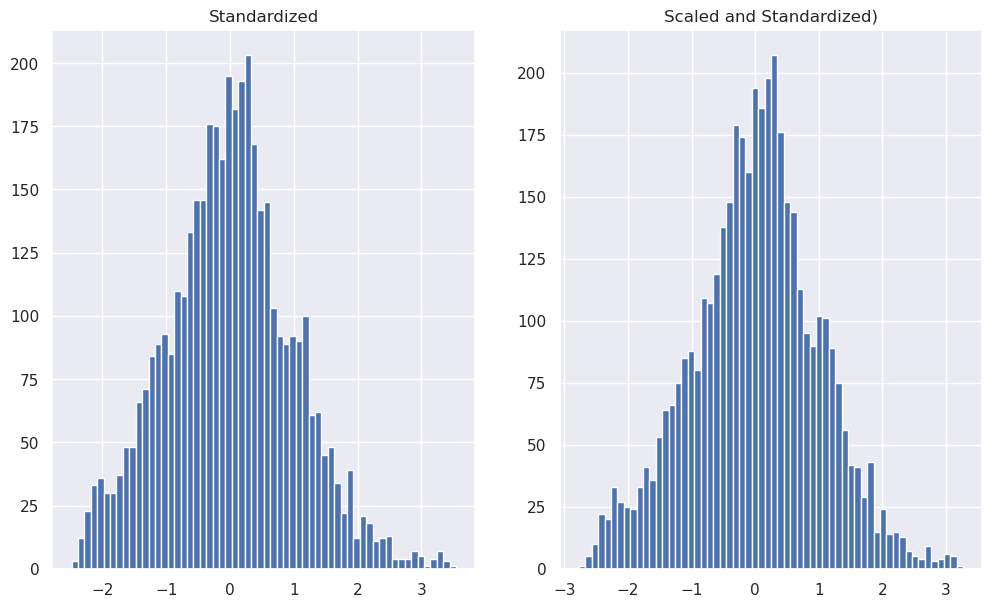

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].set_title("Standardized")
ax[0].hist(standardize(ws, ws), bins=60)

ax[1].set_title("Scaled and Standardized")
ax[1].hist(standardize(v, v), bins=60)

fig.show()

In [18]:
#| output: false
v_train_scaled = standardize(v, v)

with pm.Model() as model_ws:
    rho = pm.Normal("rho", 0, 1, shape=3)
    sigma = pm.HalfNormal("sigma", 1)
    tau = pm.Exponential("tau", 2)

    mu = pm.AR(
        "mu", 
        rho=rho,
        tau=tau,
        init_dist=pm.Normal.dist(0, 10), 
        steps=len(v_train_scaled)-3, 
    )
    
    wind_speed = pm.Normal("wind_speed", mu=mu, sigma=sigma, observed=v_train_scaled)
    
    idata_ws = pm.sample(random_seed=100)
    pm.sample_posterior_predictive(idata_ws, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rho, sigma, tau, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
Sampling: [wind_speed]


The model needs some additional tuning, as the HMC chains show some disagreement in convergence. However, as we'll see, the posterior predictive checks show excellent agreement with the observed data.

In [19]:
az.summary(idata_ws, var_names=("~mu"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho[0],0.838,0.017,0.808,0.870,0.002,0.001,79.0,140.0,1.05
rho[1],0.040,0.022,-0.002,0.080,0.001,0.001,304.0,428.0,1.02
rho[2],0.096,0.016,0.067,0.128,0.001,0.001,447.0,583.0,1.00
sigma,0.026,0.008,0.013,0.042,0.005,0.004,3.0,14.0,2.29
tau,15.959,0.430,15.142,16.746,0.133,0.098,11.0,25.0,1.12


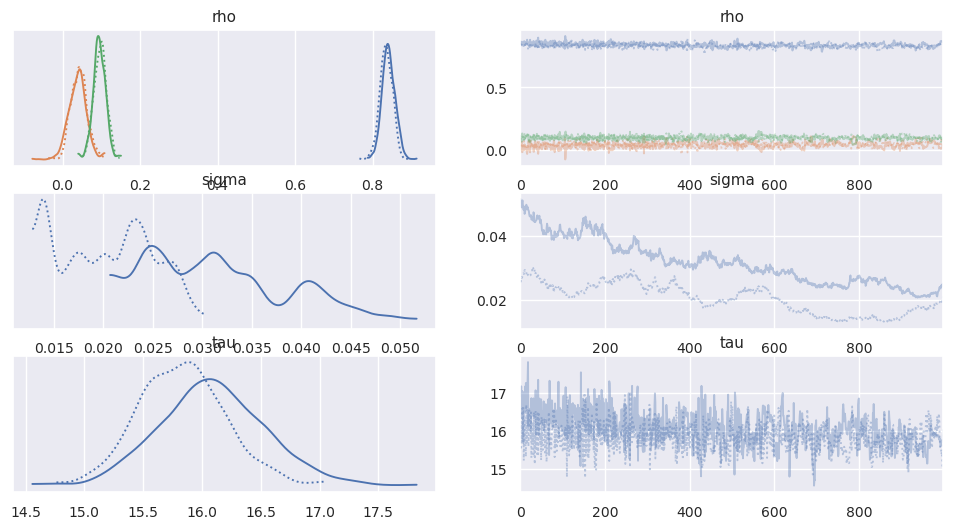

In [20]:
p = az.plot_trace(idata_ws, var_names=("~mu"))

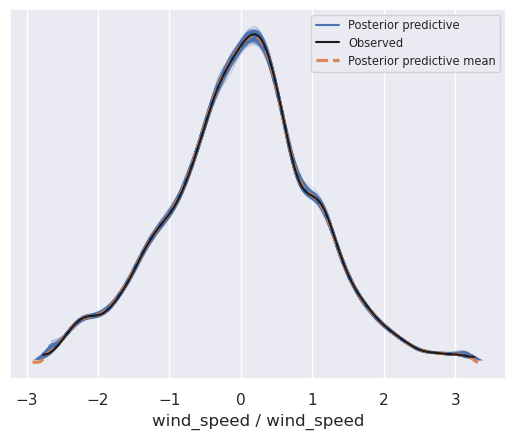

In [21]:
p = az.plot_ppc(idata_ws)

In [50]:
ppc_mean = idata_ws.posterior_predictive.mean(["chain", "draw"])

ws_pred = (ppc_mean.wind_speed.values * v.std() + v.mean())**(1/m)
rmse = mean_squared_error(y_true=ws, y_pred=ws_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.014360624296378036


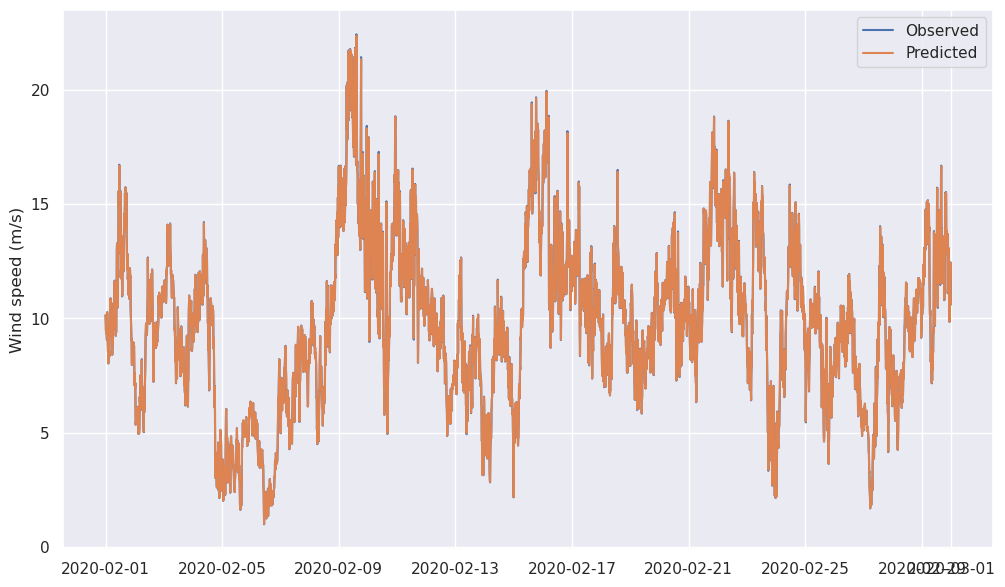

In [49]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(ws.index, ws, label="Observed")

ppc_ws = (idata_ws.posterior_predictive.wind_speed * v.std() + v.mean())**(1/m)

ax.plot(ws.index, ws_pred, label="Predicted")
ax.set_ylabel("Wind speed (m/s)")
ax.legend()
# az.plot_hdi(ws.index, ppc_ws, smooth=False, ax=ax)

### Next steps

- Complete backtesting of wind forecasting model. The `backtest` function needs some more tweaking
- Incorporate HDI (uncertainty) intervals into plots. The data is there, just needs implementation
- Connect this model to a nonparametric Power curve model that incorporates wind speed, wind direction, and other environmental variables. An ensemble of regression trees would be a strong potential choice here (i.e. Bayesian Additive Regression Tree (BART)). Gaussian Process Regression is another potential choice
- Compare results against the Power -> Power model and investigate benefits of hybrid model over Power -> Power model
- Continue lit review
- Meet with NREL Atmosphere to Electrons to Grid (A2e2G) team members, who have recently done similar work for integration of wind systems into day-ahead power markets